# News Headlines Sentiment

Use the news api to pull the latest news articles for bitcoin and ethereum and create a DataFrame of sentiment scores for each coin. 

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 
analyzer = SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize
import json
import requests
from pathlib import Path
from bs4 import BeautifulSoup
from urllib.request import urlopen
import numpy as np
%matplotlib inline

In [2]:
# Read your api key environment variable
# YOUR CODE HERE!
load_dotenv()
api_key = os.getenv("NEWS_API")

In [3]:
# Create a newsapi client
# YOUR CODE HERE!
from newsapi.newsapi_client import NewsApiClient
newsapi = NewsApiClient(api_key=api_key)

In [4]:
# Fetch the Bitcoin news articles
# YOUR CODE HERE!
bitcoin_headlines = newsapi.get_everything(q='bitcoin',language='en')

In [5]:
# Fetch the Ethereum news articles
# YOUR CODE HERE!
ethereum_headlines = newsapi.get_everything(q='ethereum',language='en')


In [6]:
# Create a function to scrape the ~entire~ text of the article
def text_scrapper(url):

    html = urlopen(url).read()
    soup = BeautifulSoup(html, features="html.parser")

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out

    # get text
    text = soup.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)

    return text

In [7]:
# Create the Bitcoin sentiment scores DataFrame
# YOUR CODE HERE!
# Create a function to gather the information from headlines
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = text_scrapper(article["url"])
            date = article["publishedAt"][:10]
            url = article["url"]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language,
                "url": url
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)
    

In [8]:
# Added a url column for potential future use to scrape the entirety of the the article
bitcoin_df = create_df(bitcoin_headlines['articles'],'en')
bitcoin_df.head()

,title,description,text,date,language,url
0,Is the New Visa Bitcoin Rewards Card Worth It?,Visa has partnered with cryptocurrency startup...,Is the New Visa Bitcoin Rewards Card Worth It?...,2020-12-03,en,https://twocents.lifehacker.com/is-the-new-vis...
1,Bitcoin passes $20k and reaches all-time high,After reaching a previous all-time high on Nov...,Bitcoin passes $20K and reaches all-time high ...,2020-12-16,en,http://techcrunch.com/2020/12/16/bitcoin-passe...
2,"Bitcoin Blows Past $20,000 Milestone",It’s been almost three years to the day since ...,"Bitcoin Blows Past $20,000 MilestoneThe A.V. C...",2020-12-16,en,https://gizmodo.com/bitcoin-blows-past-20-000-...
3,Is rising usage driving crypto’s recent price ...,Do the price gains make sense in the short-ter...,Is rising usage driving crypto’s recent price ...,2020-12-17,en,http://techcrunch.com/2020/12/17/is-rising-usa...
4,"Bitcoin is flirting with $20,000 again. How hi...","In November 2017, after an absolutely massive,...",Bitcoin is on the verge of surpassing its all-...,2020-11-20,en,https://mashable.com/article/bitcoin-20000/


In [9]:
# Initialize dictionary to hold the compound, negative, neutral and positive scores for the articles
text_sent = {'Compound':[],
                 'Negative':[],
                 'Neutral':[],
                 'Positive':[]}
# Get sentiment from articles
for index, row in bitcoin_df.iterrows():
    try:
        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["Compound"].append(text_sentiment["compound"])
        text_sent["Negative"].append(text_sentiment["neg"])
        text_sent["Neutral"].append(text_sentiment["neu"])
        text_sent["Positive"].append(text_sentiment["pos"])
        #text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass
# Add the newly created scores to the previously created bitcoin dataframe
text_sent_df = pd.DataFrame(text_sent)
bitcoin_sentiment = text_sent_df.join(bitcoin_df)
bitcoin_sentiment.head()

,Compound,Negative,Neutral,Positive,title,description,text,date,language,url
0,0.9985,0.025,0.785,0.190,Is the New Visa Bitcoin Rewards Card Worth It?,Visa has partnered with cryptocurrency startup...,Is the New Visa Bitcoin Rewards Card Worth It?...,2020-12-03,en,https://twocents.lifehacker.com/is-the-new-vis...
1,0.8442,0.027,0.879,0.094,Bitcoin passes $20k and reaches all-time high,After reaching a previous all-time high on Nov...,Bitcoin passes $20K and reaches all-time high ...,2020-12-16,en,http://techcrunch.com/2020/12/16/bitcoin-passe...
2,0.2960,0.042,0.902,0.056,"Bitcoin Blows Past $20,000 Milestone",It’s been almost three years to the day since ...,"Bitcoin Blows Past $20,000 MilestoneThe A.V. C...",2020-12-16,en,https://gizmodo.com/bitcoin-blows-past-20-000-...
3,0.9546,0.020,0.897,0.083,Is rising usage driving crypto’s recent price ...,Do the price gains make sense in the short-ter...,Is rising usage driving crypto’s recent price ...,2020-12-17,en,http://techcrunch.com/2020/12/17/is-rising-usa...
4,0.9984,0.038,0.857,0.105,"Bitcoin is flirting with $20,000 again. How hi...","In November 2017, after an absolutely massive,...",Bitcoin is on the verge of surpassing its all-...,2020-11-20,en,https://mashable.com/article/bitcoin-20000/


In [10]:
# Rearrange and drop unnecessary columns
bitcoin_sentiment = bitcoin_sentiment.drop(columns=['title','description','date','language'])
bitcoin_sentiment.head()

,Compound,Negative,Neutral,Positive,text,url
0,0.9985,0.025,0.785,0.190,Is the New Visa Bitcoin Rewards Card Worth It?...,https://twocents.lifehacker.com/is-the-new-vis...
1,0.8442,0.027,0.879,0.094,Bitcoin passes $20K and reaches all-time high ...,http://techcrunch.com/2020/12/16/bitcoin-passe...
2,0.2960,0.042,0.902,0.056,"Bitcoin Blows Past $20,000 MilestoneThe A.V. C...",https://gizmodo.com/bitcoin-blows-past-20-000-...
3,0.9546,0.020,0.897,0.083,Is rising usage driving crypto’s recent price ...,http://techcrunch.com/2020/12/17/is-rising-usa...
4,0.9984,0.038,0.857,0.105,Bitcoin is on the verge of surpassing its all-...,https://mashable.com/article/bitcoin-20000/


In [11]:
# Create the ethereum sentiment scores DataFrame
# YOUR CODE HERE!
ethereum_df = create_df(ethereum_headlines['articles'],'en')
ethereum_df.head()

,title,description,text,date,language,url
0,Smaller digital coins soar as bitcoin powers o...,Digital currencies Ethereum and XRP soared on ...,Smaller digital coins soar as bitcoin powers o...,2020-11-23,en,https://in.reuters.com/article/us-crypto-curre...
1,Smaller digital coins soar as bitcoin powers o...,Digital currencies Ethereum and XRP soared on ...,Smaller digital coins soar as bitcoin powers o...,2020-11-23,en,https://www.reuters.com/article/us-crypto-curr...
2,Smaller digital coins soar as bitcoin powers o...,Digital currencies Ethereum and XRP soared on ...,Smaller digital coins soar as bitcoin powers o...,2020-11-23,en,https://in.reuters.com/article/us-crypto-curre...
3,Crypto exchange Coinbase hit by tech trouble a...,Major U.S. cryptocurrency exchange Coinbase sa...,Crypto exchange Coinbase hit by tech trouble a...,2020-12-16,en,https://www.reuters.com/article/crypto-currenc...
4,Crypto exchange Coinbase hit by tech trouble a...,Major U.S. cryptocurrency exchange Coinbase sa...,Crypto exchange Coinbase hit by tech trouble a...,2020-12-16,en,https://in.reuters.com/article/crypto-currency...


In [12]:
# Initialize dictionary to hold the compound, negative, neutral and positive scores for the articles
text_sent = {'Compound':[],
                 'Negative':[],
                 'Neutral':[],
                 'Positive':[]}
# Get sentiment from articles
for index, row in ethereum_df.iterrows():
    try:
        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["Compound"].append(text_sentiment["compound"])
        text_sent["Negative"].append(text_sentiment["neg"])
        text_sent["Neutral"].append(text_sentiment["neu"])
        text_sent["Positive"].append(text_sentiment["pos"])
        #text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass
# Add the newly created scores to the previously created bitcoin dataframe
text_sent_df = pd.DataFrame(text_sent)
ethereum_sentiment = text_sent_df.join(ethereum_df)
ethereum_sentiment.head()

,Compound,Negative,Neutral,Positive,title,description,text,date,language,url
0,0.9753,0.038,0.859,0.103,Smaller digital coins soar as bitcoin powers o...,Digital currencies Ethereum and XRP soared on ...,Smaller digital coins soar as bitcoin powers o...,2020-11-23,en,https://in.reuters.com/article/us-crypto-curre...
1,0.9753,0.038,0.859,0.103,Smaller digital coins soar as bitcoin powers o...,Digital currencies Ethereum and XRP soared on ...,Smaller digital coins soar as bitcoin powers o...,2020-11-23,en,https://www.reuters.com/article/us-crypto-curr...
2,0.9753,0.038,0.859,0.103,Smaller digital coins soar as bitcoin powers o...,Digital currencies Ethereum and XRP soared on ...,Smaller digital coins soar as bitcoin powers o...,2020-11-23,en,https://in.reuters.com/article/us-crypto-curre...
3,-0.7003,0.066,0.893,0.041,Crypto exchange Coinbase hit by tech trouble a...,Major U.S. cryptocurrency exchange Coinbase sa...,Crypto exchange Coinbase hit by tech trouble a...,2020-12-16,en,https://www.reuters.com/article/crypto-currenc...
4,-0.7003,0.065,0.894,0.040,Crypto exchange Coinbase hit by tech trouble a...,Major U.S. cryptocurrency exchange Coinbase sa...,Crypto exchange Coinbase hit by tech trouble a...,2020-12-16,en,https://in.reuters.com/article/crypto-currency...


In [13]:
# Rearrange and drop unnecessary columns
ethereum_sentiment = ethereum_sentiment.drop(columns=['title','description','date','language'])
ethereum_sentiment.head()

,Compound,Negative,Neutral,Positive,text,url
0,0.9753,0.038,0.859,0.103,Smaller digital coins soar as bitcoin powers o...,https://in.reuters.com/article/us-crypto-curre...
1,0.9753,0.038,0.859,0.103,Smaller digital coins soar as bitcoin powers o...,https://www.reuters.com/article/us-crypto-curr...
2,0.9753,0.038,0.859,0.103,Smaller digital coins soar as bitcoin powers o...,https://in.reuters.com/article/us-crypto-curre...
3,-0.7003,0.066,0.893,0.041,Crypto exchange Coinbase hit by tech trouble a...,https://www.reuters.com/article/crypto-currenc...
4,-0.7003,0.065,0.894,0.040,Crypto exchange Coinbase hit by tech trouble a...,https://in.reuters.com/article/crypto-currency...


In [14]:
# Describe the Bitcoin Sentiment
# YOUR CODE HERE!
bitcoin_sentiment.describe()

,Compound,Negative,Neutral,Positive
count,20.000000,20.000000,20.000000,20.00000
mean,0.848925,0.037650,0.867450,0.09505
std,0.396947,0.018927,0.036926,0.03376
min,-0.700300,0.010000,0.785000,0.04100
25%,0.934300,0.021750,0.846500,0.06875
50%,0.985950,0.034500,0.870500,0.09800
75%,0.996750,0.053000,0.893000,0.11000
max,0.998500,0.068000,0.935000,0.19000


In [15]:
# Describe the Ethereum Sentiment
# YOUR CODE HERE!
ethereum_sentiment.describe()

,Compound,Negative,Neutral,Positive
count,20.000000,20.000000,20.000000,20.000000
mean,0.651065,0.039100,0.865750,0.095100
std,0.626096,0.023982,0.041444,0.043419
min,-0.700300,0.006000,0.772000,0.040000
25%,0.756850,0.020750,0.837500,0.069000
50%,0.976450,0.038000,0.859000,0.090500
75%,0.986450,0.065250,0.894500,0.111250
max,0.999600,0.076000,0.935000,0.217000


### Questions:

Q: Which coin had the highest mean positive score?

A: Ethereum has a slightly higher mean positive score with 0.0967 compared to the 0.0935 score for bitcoin.

Q: Which coin had the highest compound score?

A: Ethereum had the highest compound score with 0.999 when compared to Bitcoin, which maxed out slightly behind at 0.998.

Q. Which coin had the highest positive score?

A: Ethereum also had the highest positive score with a 0.217.

---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [16]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [17]:
# Expand the default stopwords list if necessary
# YOUR CODE HERE!
# vew list of stop words
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
# Set list of stop words and add new list of custome stop words
sw = set(stopwords.words('english'))
sw_addon = ['useprivacydo','york','tom', 'wilson','elon','musk','thomson','reutersdirectory','reutersdiscover','principlesappsnewslettersadvertise','usadvertising', 'guidelinescookiesterms','America','President','Federal Reserve','Joe Biden','Donald Trump','Jerome Powell','European Union','ECB','reuters','file','photo']
sw = sw.union(sw_addon)
print(sw)

{'york', 'my', 'what', 'now', "you'll", 'his', 'needn', 'through', 'why', 'ours', "you'd", 'hers', 'over', 'should', 'yourselves', 'having', 'between', "isn't", 'after', 'photo', 'hasn', 'she', 'ain', 'have', 'a', 'whom', 'herself', 'on', 'her', 'weren', 'because', 'President', "shan't", 'wouldn', 'are', "needn't", 'ECB', 'only', "hadn't", 'wilson', 'own', 'those', 'will', 'shouldn', 'your', 'here', 'how', 'be', 'has', 'down', 'above', 'under', 'reutersdiscover', 'if', 're', 'guidelinescookiesterms', 'file', 'their', 'out', 'we', 'i', 'doesn', 'not', "doesn't", "weren't", "that'll", 'some', "should've", 'couldn', "she's", 'they', 'an', 'so', 'did', "mustn't", 'you', 'from', 'again', 'Federal Reserve', 'once', "hasn't", 'its', 'yours', 'of', 'wasn', 'thomson', 'himself', 'nor', 'o', 'and', 'before', 'tom', 'who', 'Jerome Powell', 'while', 'off', 'by', 'doing', 'mustn', 'any', 'd', "you're", 'our', "wasn't", 'same', 'he', 'Donald Trump', 'reutersdirectory', "shouldn't", 'there', 'don', '

In [19]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    
    # Create a list of the words
    # Convert the words to lowercase
    # Remove the punctuation
    # Remove the stop words
    # Lemmatize Words into root words
    words = []
    # Remove the puntcuation
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', str(text))
    words = word_tokenize(re_clean)
    tokens = [word.lower() for word in words if word.lower() not in sw]
    return tokens
    

In [20]:
# Create a new tokens column for bitcoin
# YOUR CODE HERE!
bitcoin_sentiment['Tokens'] = bitcoin_sentiment['text'].apply(tokenizer)
bitcoin_sentiment

,Compound,Negative,Neutral,Positive,text,url,Tokens
0,0.9985,0.025,0.785,0.190,Is the New Visa Bitcoin Rewards Card Worth It?...,https://twocents.lifehacker.com/is-the-new-vis...,"[new, visa, bitcoin, rewards, card, worth, itt..."
1,0.8442,0.027,0.879,0.094,Bitcoin passes $20K and reaches all-time high ...,http://techcrunch.com/2020/12/16/bitcoin-passe...,"[bitcoin, passes, k, reaches, alltime, high, t..."
2,0.2960,0.042,0.902,0.056,"Bitcoin Blows Past $20,000 MilestoneThe A.V. C...",https://gizmodo.com/bitcoin-blows-past-20-000-...,"[bitcoin, blows, past, milestonethe, av, clubd..."
3,0.9546,0.020,0.897,0.083,Is rising usage driving crypto’s recent price ...,http://techcrunch.com/2020/12/17/is-rising-usa...,"[rising, usage, driving, cryptos, recent, pric..."
4,0.9984,0.038,0.857,0.105,Bitcoin is on the verge of surpassing its all-...,https://mashable.com/article/bitcoin-20000/,"[bitcoin, verge, surpassing, alltimehigh, pric..."
5,0.9903,0.031,0.864,0.106,You can now spend China's digital currency at ...,https://www.engadget.com/jd-com-supports-china...,"[spend, chinas, digital, currency, online, sto..."
6,0.8487,0.052,0.886,0.062,Bitcoin Could Hit $20K Again But This Time No ...,https://gizmodo.com/bitcoin-could-hit-20k-agai...,"[bitcoin, could, hit, k, time, one, caresthe, ..."
7,0.9823,0.058,0.848,0.095,"Bitcoin hits all-time high rising above $20,00...",https://www.bbc.co.uk/news/business-55343657,"[bitcoin, hits, alltime, high, rising, bbc, ne..."
8,0.9969,0.022,0.870,0.108,With investors expecting a Latin American cryp...,http://techcrunch.com/2020/12/09/with-investor...,"[investors, expecting, latin, american, crypto..."
9,0.9896,0.049,0.824,0.127,"As crypto comes back, Binance-backed Injective...",http://techcrunch.com/2020/12/03/as-crypto-com...,"[crypto, comes, back, binancebacked, injective..."


In [21]:
# Create a new tokens column for ethereum
# YOUR CODE HERE!
ethereum_sentiment['Tokens'] = ethereum_sentiment['text'].apply(tokenizer)
ethereum_sentiment

,Compound,Negative,Neutral,Positive,text,url,Tokens
0,0.9753,0.038,0.859,0.103,Smaller digital coins soar as bitcoin powers o...,https://in.reuters.com/article/us-crypto-curre...,"[smaller, digital, coins, soar, bitcoin, power..."
1,0.9753,0.038,0.859,0.103,Smaller digital coins soar as bitcoin powers o...,https://www.reuters.com/article/us-crypto-curr...,"[smaller, digital, coins, soar, bitcoin, power..."
2,0.9753,0.038,0.859,0.103,Smaller digital coins soar as bitcoin powers o...,https://in.reuters.com/article/us-crypto-curre...,"[smaller, digital, coins, soar, bitcoin, power..."
3,-0.7003,0.066,0.893,0.041,Crypto exchange Coinbase hit by tech trouble a...,https://www.reuters.com/article/crypto-currenc...,"[crypto, exchange, coinbase, hit, tech, troubl..."
4,-0.7003,0.065,0.894,0.040,Crypto exchange Coinbase hit by tech trouble a...,https://in.reuters.com/article/crypto-currency...,"[crypto, exchange, coinbase, hit, tech, troubl..."
5,-0.7003,0.066,0.893,0.041,Crypto exchange Coinbase hit by tech trouble a...,https://in.reuters.com/article/crypto-currency...,"[crypto, exchange, coinbase, hit, tech, troubl..."
6,0.9783,0.011,0.896,0.093,Crypto fund inflows hit second highest on reco...,https://uk.reuters.com/article/us-crypto-curre...,"[crypto, fund, inflows, hit, second, highest, ..."
7,0.9783,0.010,0.901,0.088,Crypto fund inflows hit second highest on reco...,https://www.reuters.com/article/us-crypto-curr...,"[crypto, fund, inflows, hit, second, highest, ..."
8,0.9992,0.011,0.772,0.217,PayPal's version of GoFundMe is called Generos...,https://mashable.com/article/paypal-generosity...,"[paypals, version, gofundme, called, generosit..."
9,0.2263,0.076,0.853,0.072,Bitcoin dives as red-hot rally hits the buffer...,https://www.reuters.com/article/crypto-currenc...,"[bitcoin, dives, redhot, rally, hits, buffers,..."


---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [22]:
from collections import Counter
from nltk import ngrams

In [60]:
# Generate the Bitcoin N-grams where N=2
# YOUR CODE HERE!
# Concatenate the Tokens
btc_ngrams = Counter(ngrams(tokenizer(bitcoin_sentiment['text'].str.cat()),n=2))
print(dict(btc_ngrams))

{('new', 'visa'): 2, ('visa', 'bitcoin'): 2, ('bitcoin', 'rewards'): 2, ('rewards', 'card'): 2, ('card', 'worth'): 2, ('worth', 'itthe'): 1, ('itthe', 'av'): 1, ('av', 'clubdeadspingizmodojalopnikjezebelkotakulifehackerthe'): 3, ('clubdeadspingizmodojalopnikjezebelkotakulifehackerthe', 'rootthe'): 3, ('rootthe', 'takeoutthe'): 3, ('takeoutthe', 'onionthe'): 3, ('onionthe', 'inventorydo'): 1, ('inventorydo', 'everything'): 1, ('everything', 'bettershopsubscribelatestskillettwo'): 1, ('bettershopsubscribelatestskillettwo', 'centsvitalsoffspringtech'): 1, ('centsvitalsoffspringtech', 'upgradevideodo'): 1, ('upgradevideodo', 'everything'): 1, ('everything', 'betterlatestskillettwo'): 1, ('betterlatestskillettwo', 'centsvitalsoffspringtech'): 1, ('centsvitalsoffspringtech', 'upgradevideocredit'): 1, ('upgradevideocredit', 'cardsis'): 1, ('cardsis', 'new'): 1, ('worth', 'itmike'): 1, ('itmike', 'winters'): 1, ('winters', 'pmfiled'): 1, ('pmfiled', 'tocredit'): 1, ('tocredit', 'cardscredit'):

In [56]:
# Generate the Ethereum N-grams where N=2
# YOUR CODE HERE!
eth_ngrams = Counter(ngrams(tokenizer(ethereum_sentiment['text'].str.cat()),n=2))
print(dict(eth_ngrams))

{('smaller', 'digital'): 6, ('digital', 'coins'): 6, ('coins', 'soar'): 6, ('soar', 'bitcoin'): 6, ('bitcoin', 'powers'): 6, ('powers', 'towards'): 6, ('towards', 'record'): 6, ('record', 'high'): 7, ('high', 'siteslogincontactsupportforphoneonlyfortabletportraitupfortabletlandscapeupfordesktopupforwidedesktopupbusiness'): 2, ('siteslogincontactsupportforphoneonlyfortabletportraitupfortabletlandscapeupfordesktopupforwidedesktopupbusiness', 'newsupdated'): 7, ('newsupdated', 'smaller'): 2, ('record', 'highby'): 3, ('highby', 'min'): 3, ('min', 'readlondon'): 5, ('readlondon', 'digital'): 3, ('digital', 'currencies'): 3, ('currencies', 'ethereum'): 3, ('ethereum', 'xrp'): 6, ('xrp', 'soared'): 6, ('soared', 'monday'): 3, ('monday', 'gaining'): 3, ('gaining', 'momentum'): 3, ('momentum', 'bitcoin'): 3, ('bitcoin', 'powered'): 3, ('powered', 'towards'): 3, ('towards', 'alltime'): 3, ('alltime', 'highfile'): 3, ('highfile', 'representation'): 3, ('representation', 'ethereum'): 3, ('ethereum

In [25]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [26]:
# Get the top 10 words for Bitcoin
# YOUR CODE HERE!
top_10_bitcoin = dict(token_count(btc_ngrams))
pd.DataFrame(list(top_10_bitcoin.items()), columns=['bigram', 'count'])


,bigram,count
0,"(alltime, high)",12
1,"(financial, services)",10
2,"(digital, currency)",9
3,"(sell, personal)",8
4,"(dow, jones)",8
5,"(twitter, hack)",6
6,"(highest, level)",6
7,"(price, bitcoin)",5
8,"(maisie, williams)",5
9,"(stock, market)",5


In [27]:
# Get the top 10 words for Ethereum
# YOUR CODE HERE!
top_10_ethereum = dict(token_count(eth_ngrams))
pd.DataFrame(list(top_10_ethereum.items()), columns=['bigram', 'count'])

,bigram,count
0,"(sell, personal)",16
1,"(virtual, currency)",14
2,"(standards, trust)",14
3,"(trust, sell)",14
4,"(personal, informationall)",14
5,"(informationall, quotes)",14
6,"(quotes, delayed)",14
7,"(delayed, minimum)",14
8,"(minimum, minutes)",14
9,"(minutes, see)",14


# Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

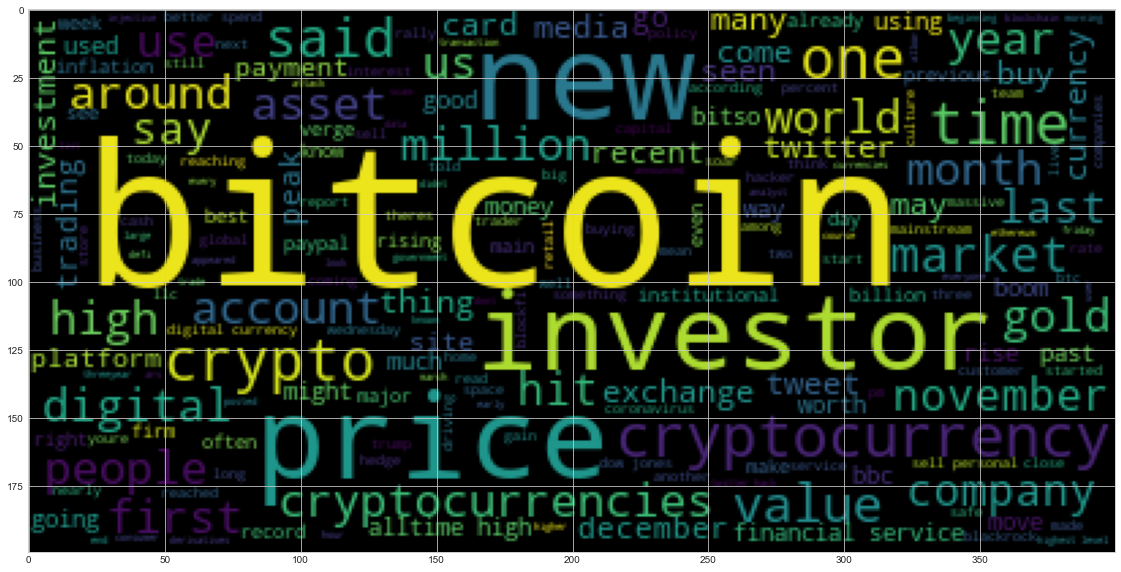

In [29]:
# Generate the Bitcoin word cloud
# YOUR CODE HERE!
wc = WordCloud().generate(' '.join(tokenizer(bitcoin_sentiment['text'].str.cat())))
plt.imshow(wc)

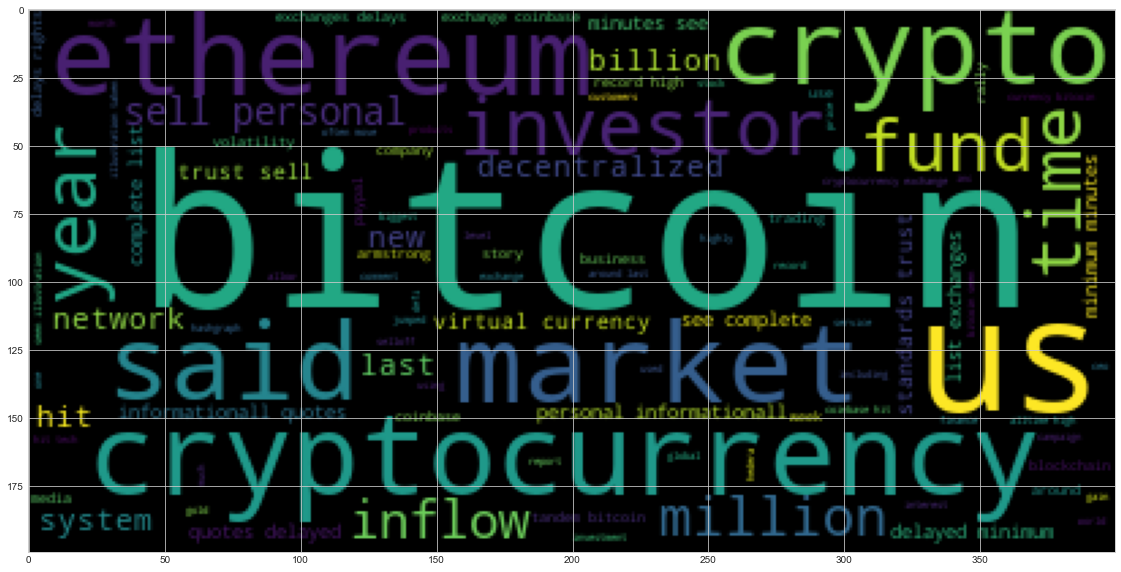

In [30]:
# Generate the Ethereum word cloud
# YOUR CODE HERE!
wc = WordCloud().generate(' '.join(tokenizer(ethereum_sentiment['text'].str.cat())))
plt.imshow(wc)

# Named Entity Recognition

In this section, you will build a named entity recognition model for both coins and visualize the tags using SpaCy.

In [31]:
import spacy
from spacy import displacy

In [32]:
# Optional - download a language model for SpaCy
# !python -m spacy download en_core_web_sm

In [33]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Bitcoin NER

In [36]:
# Concatenate all of the bitcoin text together
# YOUR CODE HERE!
bitcoin_concatenate = bitcoin_sentiment['text'].str.cat()

In [37]:
# Run the NER processor on all of the text
# YOUR CODE HERE!
doc = nlp(bitcoin_concatenate)

# Add a title to the document
# YOUR CODE HERE!

print('BITCOIN NER CONCATENATED')
displacy.render(doc, style='ent')

BITCOIN NER CONCATENATED


In [38]:
# List all Entities
# YOUR CODE HERE!
entity_list = []
entity_list = [ent.text for ent in doc.ents]
print(set(entity_list))

{'Press8', 'Huang', 'Enlarge Thomas Trutschel', 'Protocol\n', '15 minutes', 'China', 'as high as $65,000', 'the first three months', 'monthly', 'StumbleUpon', 'more than two centuries', 'Ars Orbital Transmission', 'BusinessEconomyCEO', 'over $23,000', 'James Butterfill', 'Minnesota', '20', 'November 16, 2020\n', 'CNBC', '15:41 GMT', 'ImagesBitcoin', '4,000', 'about 70 percent', 'Maisie Williams', 'the next three months', '49', 'three-year', '112', 'Casey Newton', 'Dow Jones Trademark Holdings LLC', '$175 million', 'Disclaimer', 'Twitter', '1987.Bitcoin', 'early 2018', '| ReutersDiscover Thomson ReutersDirectory of sitesLoginContactSupportfor', 'Two', '500,000', 'the past week', 'Zhu / Gettyimages\n', 'the U.S. Securities and Exchange Commission', 'January 6, 2020', 'Unique bitcoin', 'mobilemicrophoneOn', 'PoS', 'Robert Franklin', 'Timothy B. Lee\n-\n', 'Barbara', 'British', '17,868', 'Microsoft', 'the last year', 'Biden', '17-year-old', 'nearly half', 'CaresThe', 'BlackRock CIO of Fixe

In [39]:
# List of all organizations
organization_list = []
organization_list = [ent.text for ent in doc.ents if ent.label_ == 'GPE' and ent not in organization_list]
print(set(organization_list))

{'Pakistan', 'Florida', 'Benelux', 'Xbox', 'bitcoinNew York', 'Wisconsin', 'New Delhi', 'UK', 'Britain', 'Suzhou', 'Argentina', 'Thyagaraju Adinarayan', 'California', 'China', 'London', 'Georgia', 'Bitcoin Mavericks', 'bitcoin unique', 'US', 'New York', 'Massachusetts', 'BusinessEconomyCEO', 'Michigan', 'Brooklyn', 'Mexico', 'Minnesota', 'Ghazipur', 'bitcoin', 'Barbra Streisand', 'A.V.', 'India', 'S&P Opco', 'Kanye West', 'Us', 'BTSP', 'Monero', 'Australia', 'Jaqen', 'Ohio', 'Brazil', 'America', 'Shenzhen', 'Arizona', 'Italia', 'Ethereum', 'Bitcoin', 'Vox Media', 'hype', 'U.S.', 'Washington DC', 'Japan', 'Pennsylvania', 'new bitcoin', 'Blockfolio', 'New York’s', 'Shanghai', 'Venezuela'}


---

## Ethereum NER

In [40]:
# Concatenate all of the ethereum text together
# YOUR CODE HERE!
ethereum_concatenate = ethereum_sentiment['text'].str.cat()

In [41]:
# Run the NER processor on all of the text
# YOUR CODE HERE!
doc = nlp(ethereum_concatenate)

# Add a title to the document
# YOUR CODE HERE!

print('Ethereum NER CONCATENATED')
displacy.render(doc, style='ent')


Ethereum NER CONCATENATED


In [42]:
# List all Entities
# YOUR CODE HERE!
entity_list = []
entity_list = [ent.text for ent in doc.ents]
print(set(entity_list))

{'over two years', 'post-COVID', '-0.03%', '15 minutes', 'MinersPolkaswap', 'Protocol\n', 'StumbleUpon', 'AirAsia', 'BTC/JPY', 'USD/ETH\n', 'pounds).Bitcoin', 'James Butterfill', 'JPMorgan saysUS', 'Cynthia Lummis', '0.0000', 'LINE Corp', '-6.33%', '15:41 GMT', 'Google', '30%', '$15 billion', 'REUTERS', '515', 'DLA Piper', 'three-year', 'NASDAQ Comp', 'Twitter', 'Mike Wilson', '11-26 15:06:31', 'Tata Communications', 'Markets Insider and Business Insider', 'more than 25%', '314 million', 'the U.S. Securities and Exchange Commission', 'Imprint', 'ATM', 'PoS', 'Joseph Edwards', 'LG Electronics', 'the Federal reserve', 'business hours', 'just under $20,000.Bitcoin', 'KuCoin', 'approximately 7-10 minutes', '-0.14%', 'PayPal', 'Future Fallout', 'Georgia', 'more than 2%', 'Goldman Sachs', 'NASDAQ Futures', '$1.4 billion', '$429 million', '2020', 'earlier in the day', 'the last week', '24-hour', 'Hedera', 'Treasury', 'IBM', '0.70%', '60%', '-5.75%', 'Iain WithersOur Standards', 'ETH', 'Panter

In [43]:
# List all National or Political Religous Groups
norp_list = []
norp_list = [ent.text for ent in doc.ents if ent.label_ == 'NORP']
print(set(norp_list))

{'Syrians', 'Asian', 'PayPal', 'American'}
